# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementation of Neural Style Transfer with PyTorch

In [ ]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Uploading Style and Content Image (both should be of same size)

In [ ]:
# desired size of the output image
#imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    #transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/drive/MyDrive/NEURAL ART/The-Starry-Night-1200x630-1.jpg")
content_img = image_loader("/content/drive/MyDrive/NEURAL ART/nehru_museum_original.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

## 2. Visualizing the content and style images

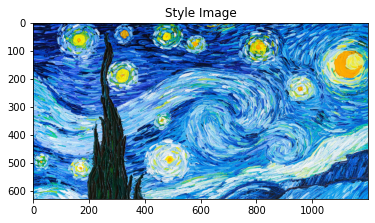

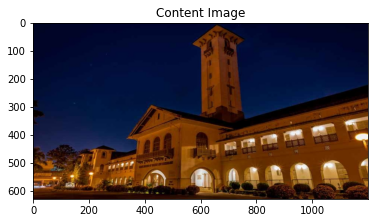

In [ ]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Codes of the different models/functions

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
# importing vgg-16 pre-trained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

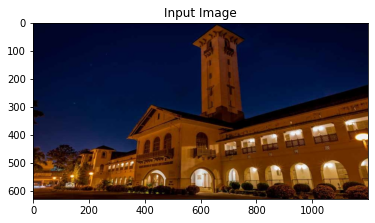

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## 4. Running the model

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 571.785400 Content Loss: 49.534191

run [100]:
Style Loss : 93.020721 Content Loss: 50.610394

run [150]:
Style Loss : 37.862648 Content Loss: 49.930225

run [200]:
Style Loss : 20.579773 Content Loss: 48.675682

run [250]:
Style Loss : 10.943940 Content Loss: 47.152058

run [300]:
Style Loss : 6.928544 Content Loss: 45.731144



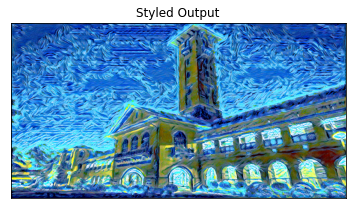

In [ ]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

## 5. Save the results!

In [ ]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "/content/drive/MyDrive/NEURAL ART/nehru_museum_stylized.jpg")

# 3D Photography using Context-aware Layered Depth Inpainting (CVPR 2020)

[project website](https://shihmengli.github.io/3D-Photo-Inpainting/)

> Colab adapted version by [Manuel Romero/@mrm8488](https://twitter.com/mrm8488)

## 1. Install required packages


In [ ]:
!pip3 install -q torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install -q opencv-python==4.2.0.32
!pip3 install -q vispy==0.6.4
!pip3 install -q moviepy==1.0.2
!pip3 install -q transforms3d==0.3.1
!pip3 install -q networkx==2.3
!pip install -q PyDrive

     |████████████████████████████████| 723.9 MB 24 kB/s 
     |████████████████████████████████| 4.0 MB 52.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0+cu100 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.4.0+cu100 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.4.0+cu100 which is incompatible.
fastai 2.6.3 requires torchvision>=0.8.2, but you have torchvision 0.5.0+cu100 which is incompatible.
     |████████████████████████████████| 28.2 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 wh

## 2. Download script and pretrained model
- It will ask for you a verification code


In [ ]:
![ -e 3d-photo-inpainting-master ] && rm -r 3d-photo-inpainting-master

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1YX3jMZOts1vJVoYtgz06zsc6IC_Gnr5Y"})
downloaded.GetContentFile('3d-photo-inpainting-master.zip')

In [ ]:
%%bash
unzip 3d-photo-inpainting-master.zip
rm 3d-photo-inpainting-master.zip
[ -e /content/3d-photo-inpainting-master/image/moon.jpg ] && rm -rf /content/3d-photo-inpainting-master/image/moon.jpg

Archive:  3d-photo-inpainting-master.zip
   creating: 3d-photo-inpainting-master/
  inflating: 3d-photo-inpainting-master/LICENSE  
   creating: 3d-photo-inpainting-master/MiDaS/
  inflating: 3d-photo-inpainting-master/MiDaS/MiDaS_utils.py  
  inflating: 3d-photo-inpainting-master/MiDaS/monodepth_net.py  
  inflating: 3d-photo-inpainting-master/MiDaS/run.py  
  inflating: 3d-photo-inpainting-master/MiDaS/model.pt  
   creating: 3d-photo-inpainting-master/depth/
  inflating: 3d-photo-inpainting-master/depth/moon.npy  
   creating: 3d-photo-inpainting-master/image/
  inflating: 3d-photo-inpainting-master/image/moon.jpg  
  inflating: 3d-photo-inpainting-master/mesh_tools.py  
  inflating: 3d-photo-inpainting-master/networks.py  
   creating: 3d-photo-inpainting-master/misc/
  inflating: 3d-photo-inpainting-master/misc/moon_40.gif  
  inflating: 3d-photo-inpainting-master/README.md  
  inflating: 3d-photo-inpainting-master/main.py  
   creating: 3d-photo-inpainting-master/video/
   creati

In [ ]:
cd 3d-photo-inpainting-master

/content/3d-photo-inpainting-master


In [ ]:
# Disable PLY generation
!sed -i 's/save_ply: True/save_ply: False/' argument.yml

In [ ]:
# Switch off screen rendering
!sed -i 's/offscreen_rendering: True/offscreen_rendering: False/g' argument.yml

## 3. Upload a picture from your filesystem with jpg extension

In [ ]:
!rm -rf /content/3d-photo-inpainting-master/image/*

In [ ]:
import os
import shutil
from google.colab import files

uploaded = files.upload()
pic_name = list(uploaded.keys())[0]

if(pic_name.split(".")[1].lower() != "jpg"):
  print("YOU MUST UPLOAD A .jpg FILE!! Re-run this cell and upload a pic with jpg extension")
  os.remove("./" + pic_name)
else:
  shutil.move("./" + pic_name, "/content/3d-photo-inpainting-master/image/" + pic_name)

Saving nehru_museum_Stylized.jpg to nehru_museum_Stylized.jpg


## 4. Execute the 3D Photo Inpainting
  - Note: The 3D photo generation process usually takes about 2-3 minutes or more depending on the available computing resources.

In [ ]:
%%time
!python main.py --config argument.yml

  0% 0/1 [00:00<?, ?it/s]Current Source ==>  nehru_museum_Stylized
initialize
device: cpu
start processing
  processing image/nehru_museum_Stylized.jpg (1/1)
torch.Size([1, 3, 224, 384])
finished
Start Running 3D_Photo ...
53.13010235415598
Moviepy - Building video video/nehru_museum_Stylized_straight-line.mp4.
Moviepy - Writing video video/nehru_museum_Stylized_straight-line.mp4

  0% 0/1 [01:44<?, ?it/s]
t:   0% 0/240 [00:00<?, ?it/s, now=None]
t:   1% 2/240 [00:00<00:20, 11.57it/s, now=None]
t:   5% 13/240 [00:00<00:04, 55.32it/s, now=None]
t:  14% 33/240 [00:00<00:01, 110.89it/s, now=None]
t:  20% 48/240 [00:00<00:01, 97.40it/s, now=None] 
t:  25% 59/240 [00:00<00:02, 66.49it/s, now=None]
t:  28% 68/240 [00:01<00:03, 56.84it/s, now=None]
t:  31% 75/240 [00:01<00:03, 51.20it/s, now=None]
t:  34% 81/240 [00:01<00:03, 50.35it/s, now=None]
t:  36% 87/240 [00:01<00:03, 44.59it/s, now=None]
t:  38% 92/240 [00:01<00:03, 45.36it/s, now=None]
t:  40% 97/240 [00:01<00:03, 43.38it/s, now=None

- **The results are stored in the following directories**
  - Corresponding depth map estimated by [MiDaS](https://github.com/intel-isl/MiDaS.git) 
      - E.g. ```/content/3d-photo-inpainting-master/depth/moon.npy```
  - Inpainted 3D mesh
      - E.g. ```/content/3d-photo-inpainting-master/mesh/moon.ply```
  - Rendered videos with circular motion
      - E.g. ```/content/3d-photo-inpainting-master/mesh/moon.mp4```

## 5. Visualize results

### Swing effect

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/3d-photo-inpainting-master/video/' + pic_name.split(".")[0] +  '_swing.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls autoplay>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Straight line effect

In [ ]:
mp4 = open('/content/3d-photo-inpainting-master/video/' + pic_name.split(".")[0] +  '_straight-line.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls autoplay>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Download it!

In [ ]:
directory = '/content/3d-photo-inpainting-master/video'
for filename in os.listdir(directory):
    if (filename.endswith(".mp4")): 
         files.download(os.path.join(directory, filename))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Citations

Citations for 3D Photography using Context-aware Layered Depth Inpainting:

This work is licensed under MIT License. See [LICENSE](LICENSE) for details. 

```
@inproceedings{Shih3DP20,
  author = {Shih, Meng-Li and Su, Shih-Yang and Kopf, Johannes and Huang, Jia-Bin},
  title = {3D Photography using Context-aware Layered Depth Inpainting},
  booktitle = {IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
  year = {2020}
}
```

Also thanks to [Manuel Romero/@mrm8488](https://twitter.com/mrm8488) for the colab adapted version

Citations for the Style Transfer Pytorch Implementation:

This is a torch implementation of the paper [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576)
by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge.